In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle

In [2]:
orders = pd.read_csv('data/orders.csv', sep=',')
products = pd.read_csv('data/products.csv', sep=',')
history = pd.read_csv('data/order_products__prior.csv', sep=',')

## Different vectorizations

The very first idea that comes to our mind, which was also used in the second homework, is to represent a user with the set of products he bought.

In [3]:
orders_small = orders[["order_id","user_id"]].sort_values(by='order_id')#.head(105629)
history_small = history[["order_id","product_id"]].sort_values(by='order_id')#.head(1000000)

The next 3 boxes are useless, but might be used at some point ater if we follow a slightly different approach.

In [4]:
consumptions = pd.merge(history_small, orders_small, on="order_id")[['user_id','product_id']]
#users_per_product = consumptions.groupby('product_id').agg(set)

In [ ]:
'''
def add_similarity(user1, user2, sim, amount):
    if user1 in  sim[user2] : # user1 and user2 are already neighbours
        sim[user1][user2]+=amount
        sim[user2][user1]+=amount
    else :     
        sim[user1][user2]=amount
        sim[user2][user1]=amount
        
def light_similarity_matrix(prod_set, nb_users):
    sim = [{} for x in range(nb_users)]
    n=0
    # sim[n] is the dictionary such that dict[m] = nb of similar products bought by m and n. If this is 0, dict[m] is not defined
    for set_users in prod_set.user_id :
        # For each pair of users
        for user1 in set_users :
            for user2 in set_users :
                if user1<user2 :
                    n+=2
                    add_similarity(user1, user2, sim, 1)
    print(n)
    return sim

sim = light_similarity_matrix(users_per_product.head(100), 206209)
'''

In [5]:
consumptions_with_details = pd.merge(consumptions,products, on="product_id")[['user_id','product_id','aisle_id','department_id']]
consumptions_with_details.head()

,user_id,product_id,aisle_id,department_id
0,202279,33120.0,86,16
1,153404,33120.0,86,16
2,23750,33120.0,86,16
3,58707,33120.0,86,16
4,166654,33120.0,86,16


In [8]:
max_user_id = max(consumptions_with_details["user_id"])
print('The greatest user id is '+str(max_user_id)+".")

The greatest user id is 206209.


In [7]:
# We split the dataframe into 2 smaller ones, because the kernel crashes at the next step if we keep the big one
consumptions_1 = consumptions_with_details[consumptions_with_details.user_id<max_user_id//2]
consumptions_2 = consumptions_with_details[consumptions_with_details.user_id>=max_user_id//2]
assert(len(consumptions_with_details)==len(consumptions_1)+len(consumptions_2))

### A - Set of aisles with total number products bought in the aisle

In [9]:
max_aisle_id = max(consumptions_with_details.aisle_id)
print("The greatest aisle id is "+str(max_aisle_id)+".")

The greatest aisle id is 134.


In [10]:
consumption_aisle_1 = consumptions_1[["user_id","product_id", "aisle_id"]].groupby(['user_id','aisle_id']).agg({'product_id': "count"})
consumption_aisle_2 = consumptions_2[["user_id","product_id", "aisle_id"]].groupby(['user_id','aisle_id']).agg({'product_id': "count"})
consumption_aisle_1.head()

product_id
user_id aisle_id            
1       21                 3
        23                 3
        24                 4
        77                 3
        88                 1

In [12]:
def init_matrix_aisle():
    np1 = []
    for w in range(max_user_id+1):
        np1.append([0 for x in range(max_aisle_id+1)])
    return np1

def to_tab_vect(consumption,mat=init_matrix_aisle()):
    '''Returns the matrix M such that M[user][aisle] = number of distinct products bought by user in aisle'''
    n=0
    n_pairs = len(consumption)
    for (user, aisle) in consumption.index :
        n+=1
        mat[user][aisle] = consumption.product_id[(user, aisle)]
        if n%250000==0 : print(str(round(100*(n/n_pairs),1))+ "% processed")
    print('Done !')
    return mat

In [13]:
user_matrix = to_tab_vect(consumption_aisle_1)
user_matrix = to_tab_vect(consumption_aisle_2, user_matrix)

6.5% processed
13.1% processed
19.6% processed
26.1% processed
32.6% processed
39.2% processed
45.7% processed
52.2% processed
58.7% processed
65.3% processed
71.8% processed
78.3% processed
84.8% processed
91.4% processed
97.9% processed
Done !
6.6% processed
13.2% processed
19.7% processed
26.3% processed
32.9% processed
39.5% processed
46.0% processed
52.6% processed
59.2% processed
65.8% processed
72.4% processed
78.9% processed
85.5% processed
92.1% processed
98.7% processed
Done !


### B - Clustering and evaluation of the best number of clusters

In [6]:
def score(k, user_mat, proportion=1):
    try : 
        sk = open("kmeans_"+str(k),"rb")            
        print("Lucky you, kmeans have already been computed !")
        kmeans = pickle.load(sk)
        sk.close()
    except FileNotFoundError :
        print("Computing kmeans...")
        kmeans = KMeans(n_clusters=k, random_state=0).fit(user_mat)
        sk = open("kmeans_"+str(k),"wb")
        pickle.dump(kmeans, sk)
        sk.close()
        print("K-means saved in file kmeans_"+str(k))
    labels = kmeans.labels_
    print("Calculating the silhouette score (this may take a while)...")
    user_mat_light = []
    labels_light = []
    if proportion==1 :
        return silhouette_score(user_mat, labels)
    else :
        for i in range(len(user_mat)):
            if rd.random()<=proportion :
                user_mat_light.append(user_mat[i])
                labels_light.append(labels[i])
        return silhouette_score(user_mat_light, labels_light)

In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import random as rd
import pickle
import matplotlib.pyplot as plt


def compute_scores(user_mat="", n_max=50, proportion=0.2,filename="scores"):
    '''Comutes as many silhouette scores as possible and registers them in file scores'''
    if user_mat=="":
        print("Loading user matrix...")
        s=open("users_matrix","rb")
        user_mat=pickle.load(s)
        s.close()
    
    for k in range(2,n_max) :
        print("\n k="+str(k))
        s=open(filename,"rb")
        scores = pickle.load(s)
        print(scores)
        s.close()
        if k in scores and scores[k]["proportion"]>=proportion+0.2:
            print('Score already calculated for k=',k,"(that is ",scores[k],")")
        else :
            print('Computing the score for K-means with '+str(k)+" clusters...")
            s=open(filename,"rb")
            scores = pickle.load(s)
            s.close()
            sc =score(k, user_mat, proportion)
            if k in scores : 
                # Make a weighted average with previously obtained scores, if tey exist
                prop = proportion + scores[k]["proportion"]   
                sc = (sc*proportion + scores[k]["score"]*scores[k]["proportion"])/prop
            else : prop = proportion
            scores[k] = {"score":sc, "proportion":prop}
            print("Score calculated for k=",k," :",scores[k])
            s=open(filename,"wb")
            pickle.dump(scores,s)
            s.close()
            print('Scores saved in file "'+filename+'" under pickle format')               

In [ ]:
def print_scores() :
    s=open("scores",'rb')
    scores = pickle.load(s)
    s.close()
    X,Y, Z=[],[],[]
    for k in scores :
        X.append(k)
        Y.append(scores[k]["score"])
        Z.append(scores[k]["proportion"])
    plt.plot(X,Y,"r")
    plt.plot(X,Z,"b")

In [26]:
compute_scores("",50,0.1)

Loading user matrix...


KeyboardInterrupt: 

{'score': 0.6592836313223515, 'proportion': 0.05}
{'score': 0.5087411803582508, 'proportion': 0.05}
{'score': 0.40091164490961056, 'proportion': 0.05}
{'score': 0.3879837713089932, 'proportion': 0.05}
{'score': 0.38217006592530667, 'proportion': 0.05}
{'score': 0.3338921254578145, 'proportion': 0.05}
{'score': 0.30346340599248917, 'proportion': 0.05}
{'score': 0.2999561464484978, 'proportion': 0.05}
{'score': 0.2723134633466197, 'proportion': 0.05}


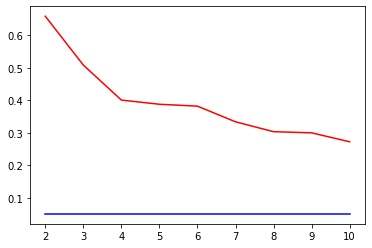

In [24]:
print_scores()

In [28]:
def get_avg_vector(number_clusters, cluster_index, users_matrix ="") :
    '''Returns the vector representation of cluster number cluster_index when clustering the users with number_clusters'''
    if users_matrix=="" :
        s = open("users_matrix",'rb')
        users_matrix = pickle.load(s)
        s.close()
    try :
        # If we already computed kmeans, we just load it
        s=open("kmeans_"+str(number_clusters),'rb')
        kmeans = pickle.load(s)
        s.close()
    except FileNotFoundError :
        # Else, we compute kmeans with the right number of clusters and save the file
        kmeans = KMeans(n_clusters= number_clusters).fit(user_matrix)
        s = open("kmeans_"+str(k),"wb")
        pickle.dump(kmeans, sk)
        s.close()

    # Initialize a zero vector    
    v = [0 for x in range(1,len(users_matrix[0]))]
    number_users_in_cluster = 0.
    for user_index in range(1,len(users_matrix)) :
        if kmeans.labels_[user_index]==cluster_index :
            number_users_in_cluster+=1
            for aisle_id in range(1,len(users_matrix[user_index])) :
                # Increment, for each aisle, the vector by the contribution of user n° user_index
                v[aisle_id-1]+=users_matrix[user_index][aisle_id]
    print("N° of users in cluster : "+str(number_users_in_cluster))
    return [x/number_users_in_cluster for x in v]

In [29]:
get_avg_vector(4,3)

N° of users in cluster : 12842.0


[0.3951097959819343,
 0.45047500389347456,
 2.6468618595234386,
 0.8719046877433422,
 0.2700513938638841,
 0.14717333748637285,
 0.16578414577168665,
 0.1432798629496963,
 1.0953122566578415,
 0.02826662513627161,
 0.0654103722161657,
 0.18813268961220994,
 0.4964180034262576,
 0.6964647251206977,
 0.10925089549914344,
 2.262653792244199,
 1.5808285313814048,
 0.10418937860146395,
 1.21834605201682,
 0.23983803145927426,
 5.368478430151066,
 0.11267715309141878,
 0.7187353994704875,
 23.12622644447905,
 0.3562529201059025,
 0.9000934433888802,
 0.05528733842080673,
 0.04563152156984893,
 0.3213673882572808,
 0.37034729792867155,
 2.9827908425478897,
 0.7780719514094377,
 0.04913564865285781,
 0.29496963089861394,
 0.723952655349634,
 1.3378757202927893,
 2.0401027877277684,
 1.407568914499299,
 0.18283756424232986,
 0.14639464257903753,
 0.1504438560971811,
 0.43279862949696307,
 0.515106681202305,
 0.012381249026631366,
 1.4221305092664693,
 0.05435290453200436,
 0.24061672636660955,


In [30]:
get_avg_vector(4,2)

N° of users in cluster : 3135.0


[0.5263157894736842,
 0.7655502392344498,
 3.5208931419457734,
 1.3556618819776713,
 0.4360446570972887,
 0.23444976076555024,
 0.30494417862838913,
 0.1773524720893142,
 1.874322169059011,
 0.04401913875598086,
 0.08771929824561403,
 0.2864433811802233,
 0.8322169059011164,
 1.481658692185008,
 0.19968102073365232,
 5.20956937799043,
 2.856778309409888,
 0.17192982456140352,
 2.4539074960127594,
 0.33014354066985646,
 9.274322169059012,
 0.14641148325358852,
 0.9623604465709729,
 47.26411483253589,
 0.5566188197767146,
 1.2258373205741626,
 0.043381180223285486,
 0.025199362041467305,
 0.5668261562998405,
 0.6861244019138756,
 4.357575757575757,
 0.94896331738437,
 0.09250398724082935,
 0.46858054226475276,
 1.5078149920255184,
 2.3566188197767146,
 2.9154704944178627,
 1.821371610845295,
 0.4028708133971292,
 0.14800637958532695,
 0.10590111642743222,
 0.7432216905901117,
 0.835725677830941,
 0.007974481658692184,
 1.9626794258373206,
 0.0634768740031898,
 0.3776714513556619,
 0.3036

In [31]:
get_avg_vector(4,1)

N° of users in cluster : 149011.0


[0.04445980498084034,
 0.04407728288515613,
 0.24009636872445658,
 0.13674158283616647,
 0.04228546885800377,
 0.026716148472260438,
 0.01968311064283845,
 0.026139009871754434,
 0.12297078739153486,
 0.008328244223580809,
 0.02640744643012932,
 0.02163598660501574,
 0.05868023166074988,
 0.06053915482749596,
 0.011046164377126522,
 0.14028494540671493,
 0.1998375958821832,
 0.008824851856574346,
 0.1416942373381831,
 0.05321083678386159,
 0.5143580004160767,
 0.02807846400601298,
 0.11903819181134279,
 1.404627846266383,
 0.03436659038594466,
 0.1487272751676051,
 0.06427042298890685,
 0.043721604445309405,
 0.03974203246740174,
 0.040205085530598414,
 0.33698854446987137,
 0.2622155411345471,
 0.007549778204293643,
 0.053593358879545805,
 0.058317842306943785,
 0.14259349980873895,
 0.36002711209239585,
 0.3025280012884955,
 0.0112676245377858,
 0.027253021589010207,
 0.06443819583789116,
 0.06384092449550705,
 0.07635006811577669,
 0.010844836958345356,
 0.2082396601593171,
 0.02270

In [32]:
get_avg_vector(4,0)

N° of users in cluster : 41221.0


[0.16537687101234808,
 0.20319739938380924,
 1.1048979888891584,
 0.4762135804565634,
 0.15196137890880862,
 0.0800077630334053,
 0.07750903665607337,
 0.08058999053880304,
 0.5335387302588487,
 0.01989277310108925,
 0.04737876325174062,
 0.08660634142791296,
 0.23507435530433518,
 0.3225540379903447,
 0.05240047548579607,
 0.9356396011741588,
 0.7627180320710317,
 0.04019795735183523,
 0.574464471992431,
 0.13975886077484778,
 2.362412362630698,
 0.06814487761092647,
 0.3718735595934111,
 8.67412241333301,
 0.1513548919240193,
 0.4823269692632396,
 0.07382159578855438,
 0.06744135270857088,
 0.15814754615365953,
 0.19329953179204773,
 1.3898255743431747,
 0.5996215521214915,
 0.030494165595206325,
 0.1619320249387448,
 0.321632177773465,
 0.597777831687732,
 1.181994614395575,
 0.9447854249047816,
 0.07287547609228306,
 0.08299167899856869,
 0.13383954780330415,
 0.2502607894034594,
 0.2586060503141603,
 0.015744402125130393,
 0.6780039300356614,
 0.04694209262269232,
 0.1046068751364